In [80]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from langdetect import detect, DetectorFactory
import textstat
from wordcloud import WordCloud

In [64]:

# --- Rutas relativas desde el notebook ---
DATA_PATH = "../data/processed/dataset_clean_v1.csv"
OUTDIR = "../docs/report_assets"

# Crear carpeta de salidas si no existe
os.makedirs(OUTDIR, exist_ok=True)

# Cargar dataset
df = pd.read_csv(DATA_PATH, encoding="utf-8", low_memory=False)
print("Shape:", df.shape)
df.head()



Shape: (182753, 9)


texto_original resumen source  \
0  NIS-LL: a subscale (of 37-item NIS questionnai...     NaN   test   
1  Norfolk QOL-DN: 35-item participant-rated ques...     NaN   test   
2  Karnofsky performance scale was used for ratin...     NaN   test   
3  Safety And Efficacy Evaluation Of Fx-1006A In ...     NaN   test   
4  Criteria for clinically significant changes: S...     NaN   test   

               doc_id split label  source_dataset source_bucket  has_pair  
0  NCT00925002.txt#L1  test   NaN  clinicaltrials          test     False  
1  NCT00925002.txt#L2  test   NaN  clinicaltrials          test     False  
2  NCT00925002.txt#L3  test   NaN  clinicaltrials          test     False  
3  NCT00925002.txt#L4  test   NaN  clinicaltrials          test     False  
4  NCT00925002.txt#L5  test   NaN  clinicaltrials          test     False

In [65]:
df.columns


Index(['texto_original', 'resumen', 'source', 'doc_id', 'split', 'label',
       'source_dataset', 'source_bucket', 'has_pair'],
      dtype='object')

In [66]:
df["label"].value_counts()

label
non_pls    80737
pls        48997
Name: count, dtype: int64

In [67]:
df["resumen"] = df["resumen"].fillna("").astype(str)

print("Tipo de dato:", df["resumen"].dtype)
print("Ejemplo de valores:", df["resumen"].head())

print("% con resumen:", (df["resumen"].str.len() > 0).mean() * 100)



Tipo de dato: object
Ejemplo de valores: 0    
1    
2    
3    
4    
Name: resumen, dtype: object
% con resumen: 26.810503794739347


In [68]:
# Normalizar columnas principales
for col in ["texto_original", "resumen"]:
    if col not in df.columns:
        df[col] = ""
    df[col] = df[col].fillna("").astype(str)

# Longitudes en caracteres y palabras
df["len_src"] = df["texto_original"].str.len()
df["len_pls"] = df["resumen"].str.len()

df["wc_src"] = df["texto_original"].str.split().apply(len)
df["wc_pls"] = df["resumen"].str.split().apply(len)

# Ratios de reducción (solo si hay resumen)
df["len_ratio_pls_src"] = np.where(df["len_src"] > 0, df["len_pls"] / df["len_src"], np.nan)
df["wc_ratio_pls_src"]  = np.where(df["wc_src"] > 0, df["wc_pls"] / df["wc_src"], np.nan)

df.head()


texto_original resumen source  \
0  NIS-LL: a subscale (of 37-item NIS questionnai...           test   
1  Norfolk QOL-DN: 35-item participant-rated ques...           test   
2  Karnofsky performance scale was used for ratin...           test   
3  Safety And Efficacy Evaluation Of Fx-1006A In ...           test   
4  Criteria for clinically significant changes: S...           test   

               doc_id split label  source_dataset source_bucket  has_pair  \
0  NCT00925002.txt#L1  test   NaN  clinicaltrials          test     False   
1  NCT00925002.txt#L2  test   NaN  clinicaltrials          test     False   
2  NCT00925002.txt#L3  test   NaN  clinicaltrials          test     False   
3  NCT00925002.txt#L4  test   NaN  clinicaltrials          test     False   
4  NCT00925002.txt#L5  test   NaN  clinicaltrials          test     False   

   len_src  len_pls  wc_src  wc_pls  len_ratio_pls_src  wc_ratio_pls_src  
0      895        0     129       0                0.0               0.0  
1      671        0     102       0                0.0               0.0  
2      992        0     138       0                0.0               0.0  
3       85        0      11       0                0.0               0.0  
4      672        0     112       0                0.0               0.0

In [69]:
# Proporción de filas sin resumen
pct_missing = (df["len_pls"] == 0).mean() * 100
print(f"Porcentaje de ejemplos sin resumen: {pct_missing:.2f}%")

# Revisar duplicados
dup_count = df.duplicated(subset=["texto_original","resumen"]).sum()
print(f"Número de duplicados exactos (texto+resumen): {dup_count}")

# Valores vacíos en general
df.isna().sum()


Porcentaje de ejemplos sin resumen: 73.19%
Número de duplicados exactos (texto+resumen): 0


texto_original           0
resumen                  0
source                   0
doc_id                   0
split                    0
label                53019
source_dataset           0
source_bucket            0
has_pair                 0
len_src                  0
len_pls                  0
wc_src                   0
wc_pls                   0
len_ratio_pls_src    48997
wc_ratio_pls_src     48997
dtype: int64

In [70]:
def describe_series(s):
    s = pd.to_numeric(s, errors="coerce").dropna()
    return pd.Series({
        "count": s.count(),
        "mean": s.mean(),
        "std": s.std(),
        "min": s.min(),
        "25%": s.quantile(0.25),
        "50%": s.median(),
        "75%": s.quantile(0.75),
        "max": s.max()
    })

stats_len_src = describe_series(df["len_src"])
stats_len_pls = describe_series(df.loc[df["len_pls"] > 0, "len_pls"])
stats_wc_src  = describe_series(df["wc_src"])
stats_wc_pls  = describe_series(df.loc[df["wc_pls"] > 0, "wc_pls"])

summary_stats = pd.DataFrame({
    "len_src": stats_len_src,
    "len_pls": stats_len_pls,
    "wc_src": stats_wc_src,
    "wc_pls": stats_wc_pls
})

summary_stats.to_csv(os.path.join(OUTDIR, "length_stats.csv"), encoding="utf-8")
summary_stats



len_src       len_pls         wc_src        wc_pls
count  182753.000000  48997.000000  182753.000000  48997.000000
mean      209.254672    338.746454      31.629401     52.614691
std       290.009165    315.118099      44.231104     48.744290
min         0.000000     30.000000       0.000000      2.000000
25%         0.000000    107.000000       0.000000     16.000000
50%        84.000000    252.000000      14.000000     39.000000
75%       303.000000    469.000000      44.000000     73.000000
max      4703.000000   4792.000000     774.000000    741.000000

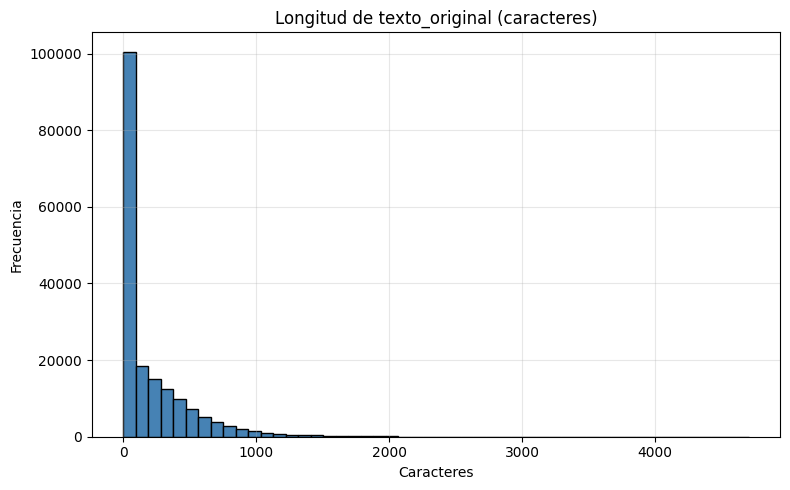

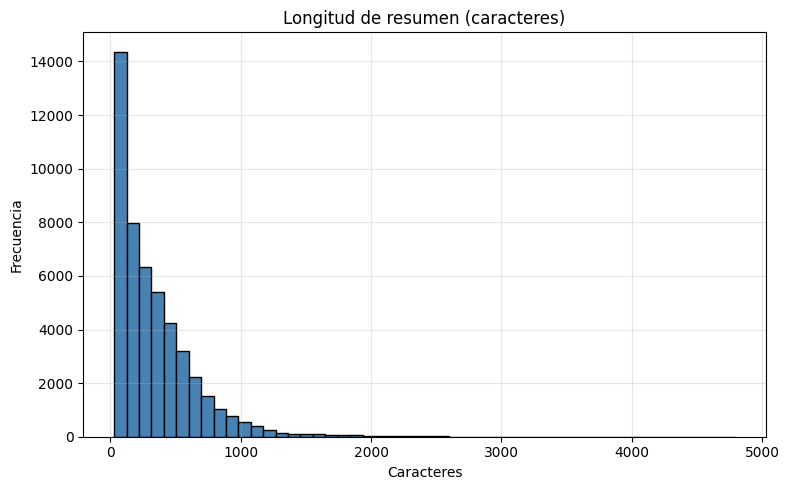

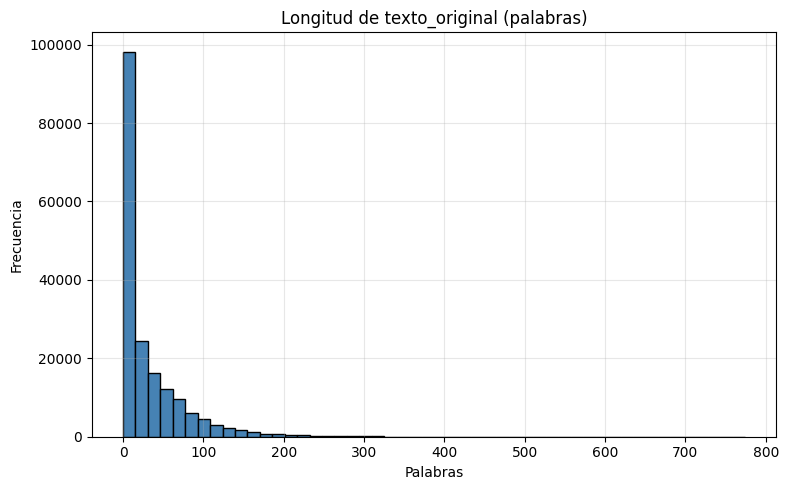

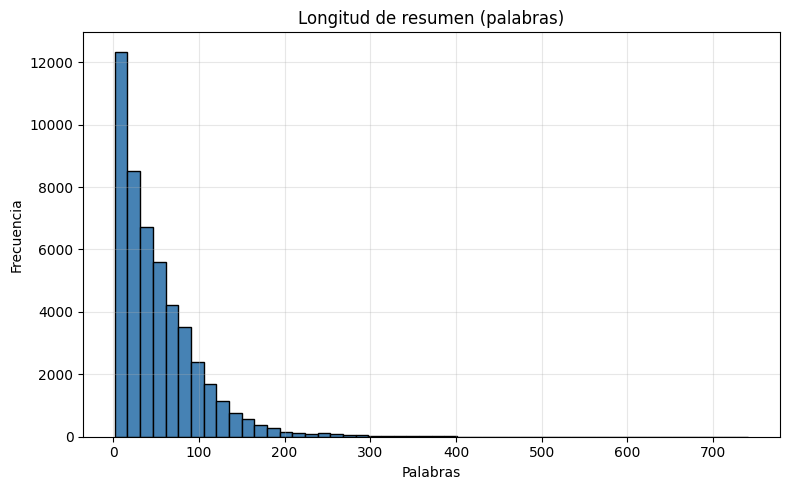

In [71]:
def save_hist(series, title, xlabel, outfile, bins=50):
    series = pd.to_numeric(series, errors="coerce").dropna()
    plt.figure(figsize=(8,5))
    plt.hist(series, bins=bins, color="steelblue", edgecolor="black")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Frecuencia")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(outfile, dpi=140)
    plt.show()



save_hist(df["len_src"], "Longitud de texto_original (caracteres)", "Caracteres", os.path.join(OUTDIR, "hist_len_src.png"))
save_hist(df.loc[df["len_pls"] > 0, "len_pls"], "Longitud de resumen (caracteres)", "Caracteres", os.path.join(OUTDIR, "hist_len_pls.png"))
save_hist(df["wc_src"], "Longitud de texto_original (palabras)", "Palabras", os.path.join(OUTDIR, "hist_wc_src.png"))
save_hist(df.loc[df["wc_pls"] > 0, "wc_pls"], "Longitud de resumen (palabras)", "Palabras", os.path.join(OUTDIR, "hist_wc_pls.png"))



In [83]:

# Textos más largos
longest = df.sort_values("len_src", ascending=False).head(20)
longest.to_csv(os.path.join(OUTDIR, "examples_longest_texts.csv"), index=False, encoding="utf-8")

# Textos sin resumen
no_pls = df[df["len_pls"] == 0].head(20)
no_pls.to_csv(os.path.join(OUTDIR, "examples_missing_pls.csv"), index=False, encoding="utf-8")

# Mostrar 3 más largos
longest[["texto_original","len_src"]].head(3)


texto_original  len_src
38527  Twelve RCTs (476 participants) were included. ...     4703
42735  We included 138 studies (23,480,668 participan...     4048
26800  Eleven studies (881 participants) were include...     3978

C:\Users\gabri\AppData\Local\Temp\ipykernel_20940\3533032555.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df["wc_src"], label="texto_original", shade=True)
C:\Users\gabri\AppData\Local\Temp\ipykernel_20940\3533032555.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df.loc[df["wc_pls"] > 0, "wc_pls"], label="resumen", shade=True)


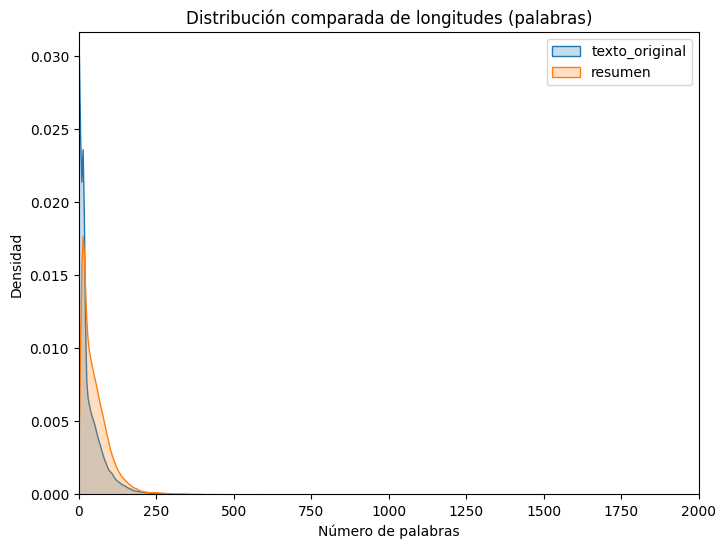

In [73]:


plt.figure(figsize=(8,6))
sns.kdeplot(df["wc_src"], label="texto_original", shade=True)
sns.kdeplot(df.loc[df["wc_pls"] > 0, "wc_pls"], label="resumen", shade=True)
plt.xlim(0, 2000)  # recorta la cola larga
plt.xlabel("Número de palabras")
plt.ylabel("Densidad")
plt.title("Distribución comparada de longitudes (palabras)")
plt.legend()
plt.show()


In [75]:
print("Porcentaje de ejemplos sin resumen:", (df["wc_pls"] == 0).mean() * 100)
print("Duplicados (texto+resumen):", df.duplicated(subset=["texto_original","resumen"]).sum())
print("Con pares reales:", df["has_pair"].sum(), " | Sueltos:", (~df["has_pair"]).sum())


Porcentaje de ejemplos sin resumen: 73.18949620526065
Duplicados (texto+resumen): 0
Con pares reales: 0  | Sueltos: 182753


In [76]:
counts = (
    df.groupby(["source_dataset","split","label"])
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)
print(counts)


  source_dataset  split    label  count
2       cochrane  train  non_pls  64720
3       cochrane  train      pls  36804
0       cochrane   test  non_pls  16017
1       cochrane   test      pls   9453
5         pfizer  train      pls   2137
4         pfizer   test      pls    603


In [77]:


DetectorFactory.seed = 42

sample = df["texto_original"].sample(500, random_state=42)
langs = sample.apply(lambda x: detect(x) if len(x.split()) > 5 else "unk")

langs.value_counts(normalize=True).mul(100).round(2)


texto_original
en     70.2
unk    29.2
de      0.2
it      0.2
ca      0.2
Name: proportion, dtype: float64

In [78]:

df["flesch_src"] = df["texto_original"].apply(lambda x: textstat.flesch_reading_ease(x) if len(x.split())>5 else None)
df["flesch_pls"] = df["resumen"].apply(lambda x: textstat.flesch_reading_ease(x) if len(x.split())>5 else None)

df[["flesch_src","flesch_pls"]].describe()


flesch_src    flesch_pls
count  130027.000000  48065.000000
mean       39.557322     36.392343
std        29.103554     23.500377
min      -151.755000   -153.560000
25%        19.150455     23.920000
50%        38.517554     37.644737
75%        60.257061     50.665000
max       120.035833    115.130000

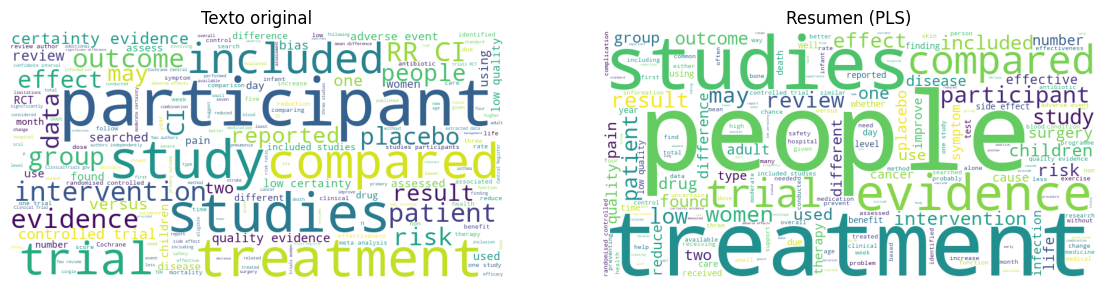

In [81]:

text_src = " ".join(df["texto_original"].sample(1000, random_state=42))
text_pls = " ".join(df.loc[df["wc_pls"] > 0, "resumen"].sample(1000, random_state=42))

wc_src = WordCloud(width=800, height=400, background_color="white").generate(text_src)
wc_pls = WordCloud(width=800, height=400, background_color="white").generate(text_pls)

plt.figure(figsize=(14,6))
plt.subplot(1,2,1); plt.imshow(wc_src); plt.axis("off"); plt.title("Texto original")
plt.subplot(1,2,2); plt.imshow(wc_pls); plt.axis("off"); plt.title("Resumen (PLS)")
plt.show()
